In [1]:
# Set up all the required imports for the project
import requests
from io import BytesIO
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
from skimage.color import rgb2hsv, hsv2rgb

In [2]:
# Function that specifies if a game is after 2015 
def in_date(soup):
    try:
        return int(soup.find('span').next[1:-1])>2015
    except:
        return False

In [3]:
# Get a big list of the games to identify, this is the first 15 pages of BGG games, and is enough to find over 1000 games in the last 5 years
games = []
for i in range(1,15):
    url = 'https://boardgamegeek.com/browse/boardgame/page/'+str(i)+'?sort=numvoters&sortdir=desc'
    soup = BeautifulSoup(requests.get(url).text, 'html.parser')
    games.extend([x.find_all('a')[1]['href'] for x in soup.find_all(id="row_")])

In [4]:
# Test one entry to make sure things are working
import json
import statistics
import sys
from pprint import pprint
from skimage.io import imread
url = 'https://boardgamegeek.com/boardgame/13/catan/stats'
soup = BeautifulSoup(requests.get(url).text, 'html.parser')
image_url = json.loads(soup.find_all('script')[-1].next)['image']
image = imread(BytesIO(requests.get(image_url).content))
intensity = image.mean()
age_string = soup.find_all('script')[1].next
data = json.loads(age_string.split('\n')[9].split(' = ')[1][:-1])['item']
print((intensity,
       int(data['minplaytime']),
       int(data['maxplaytime']),
       float(data['stats']['avgweight']),
       int(data['polls']['playerage'][:-1]),
       int(data['stats']['numowned']),
       image.mean()))

(123.78855052583448, 60, 120, 2.3252, 8, 146719, 123.78855052583448)


In [5]:
# this goes through each of the chosen games, and gets the box art image, as well as other stats from Board Game Geek
import json
import statistics
import sys
from skimage.io import imread
params = []
total = len(games)
sys.stdout.write('0 of '+str(total))
for game in games:
    try:
        url = 'https://boardgamegeek.com'+game+'/stats'
        soup = BeautifulSoup(requests.get(url).text, 'html.parser')
        image_url = json.loads(soup.find_all('script')[-1].next)['image']
        content = BytesIO(requests.get(image_url).content)
        image = imread(content)
        intensity = image.mean()
        data_string = soup.find_all('script')[1].next
        data = json.loads(data_string.split('\n')[9].split(' = ')[1][:-1])['item']
        params.append((intensity,
                       int(data['minplaytime']),
                       int(data['maxplaytime']),
                       float(data['stats']['avgweight']),
                       int(data['polls']['playerage'][:-1]),
                       int(data['stats']['numowned'])))
    except Exception as e: print(str(e))
    sys.stdout.write('\r')
    sys.stdout.write(str(len(params))+' of '+str(total))
    sys.stdout.flush()
    if len(params) >= 1000:
        # if we have the 1000 games we need, stop looking for more
        break

70 of 1400Unterminated string starting at: line 1 column 25701 (char 25700)
81 of 1400Unterminated string starting at: line 1 column 23471 (char 23470)
86 of 1400Unterminated string starting at: line 1 column 24733 (char 24732)
95 of 1400Unterminated string starting at: line 1 column 19478 (char 19477)
108 of 1400Unterminated string starting at: line 1 column 19373 (char 19372)
110 of 1400Unterminated string starting at: line 1 column 20625 (char 20624)
152 of 1400Unterminated string starting at: line 1 column 26195 (char 26194)
190 of 1400Unterminated string starting at: line 1 column 21023 (char 21022)
259 of 1400Unterminated string starting at: line 1 column 25007 (char 25006)
282 of 1400Unterminated string starting at: line 1 column 24140 (char 24139)
300 of 1400invalid literal for int() with base 10: '6–1'
549 of 1400Unterminated string starting at: line 1 column 19143 (char 19142)
599 of 1400Unterminated string starting at: line 1 column 21043 (char 21042)
606 of 1400Unterminated

In [6]:
# Turn all the statistics into numpy arrays so that they are easier to work with.
import numpy as np
intensity, minplaytime, maxplaytime, avgweight, playerage, numowned = zip(*params)
intensity = np.array(intensity)
minplaytime = np.array(minplaytime)
maxplaytime = np.array(maxplaytime) 
avgweight = np.array(avgweight)
playerage = np.array(playerage) 
numowned = np.array(numowned)
averageplaytime = (minplaytime+maxplaytime)/2.0

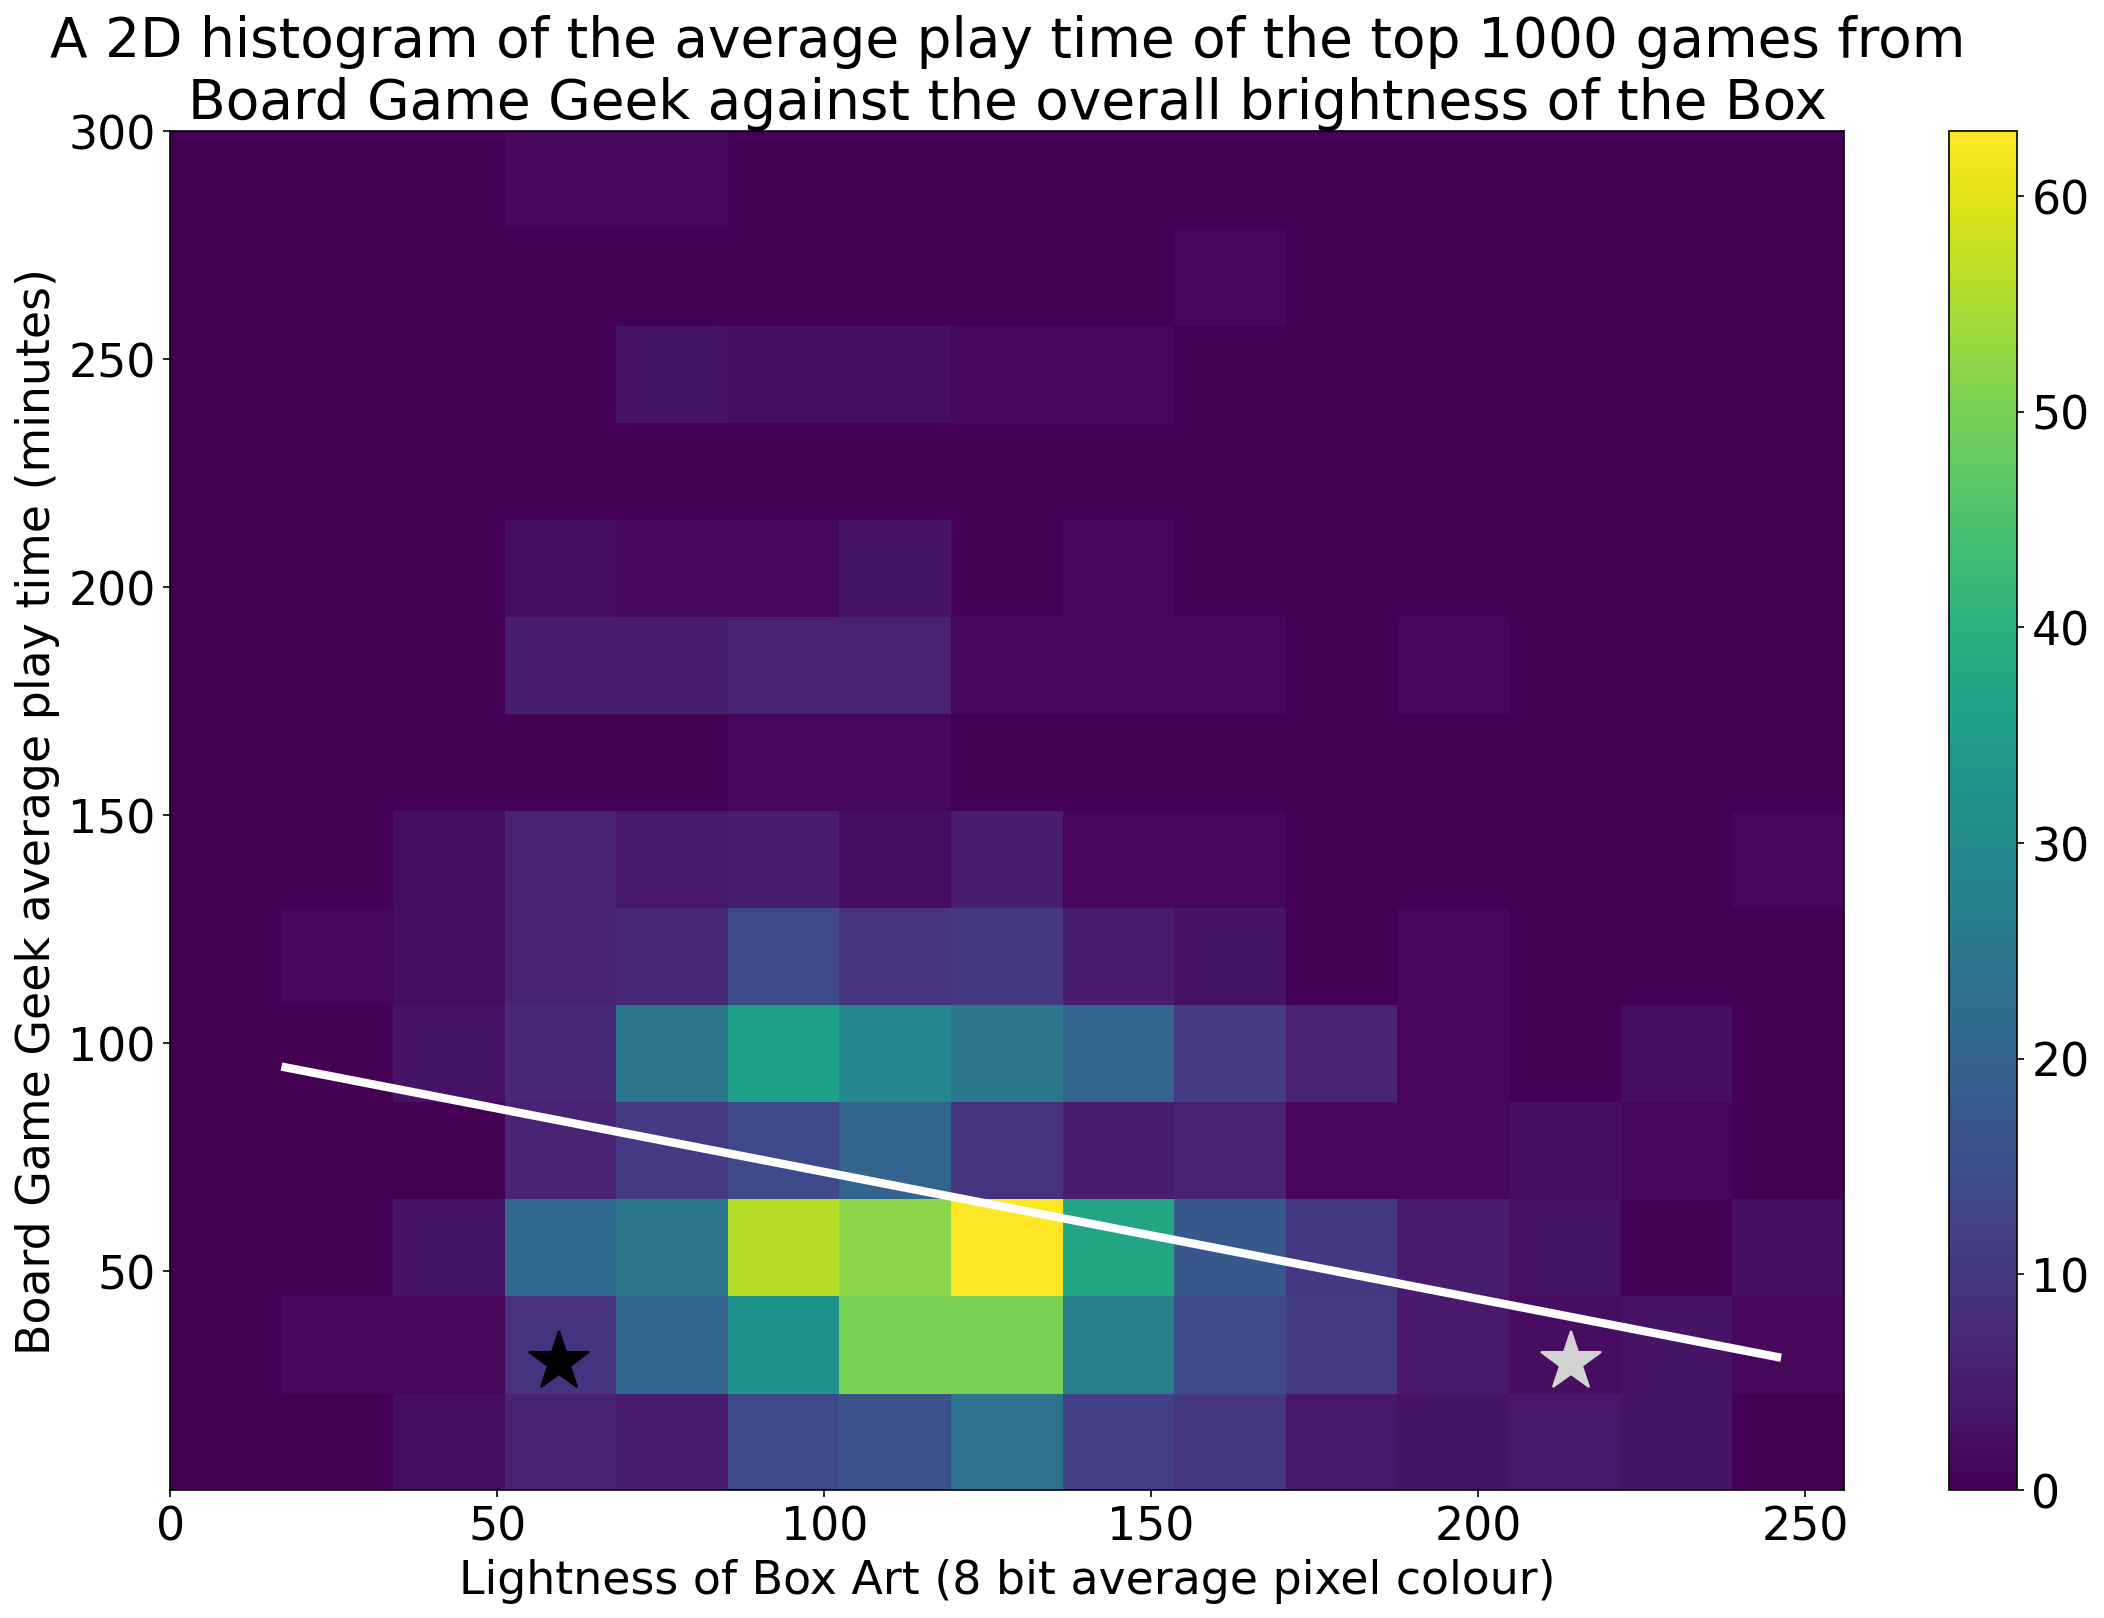

In [7]:
# Create the main plot for the paper using matplotlib, bu changing x and y will allow other values from above to be plotted.
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 12), dpi= 150, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
x = intensity 
y = averageplaytime
x_bins = np.linspace(0,256,16)
y_bins = np.linspace(y.min(),300,15)
plt.hist2d(x, y, bins=[x_bins,y_bins])
plt.title('A 2D histogram of the average play time of the top 1000 games from\nBoard Game Geek against the overall brightness of the Box')
plt.xlabel('Lightness of Box Art (8 bit average pixel colour)')
plt.ylabel('Board Game Geek average play time (minutes)')
plt.colorbar()
from numpy.polynomial.polynomial import polyfit
pf = polyfit(x, y, 1)
plt.plot(np.unique(x), pf[0] + pf[1] * np.unique(x), '-', label='Trend', linewidth=4, color='white')

lightval = imread("LightBox.png").mean()
darkval = imread("DarkBox.png").mean()

plt.plot(lightval, 30, '*', label='Light', color='lightgray', markersize=30)
plt.plot(darkval, 30, '*', label='Light', color='black', markersize=30)

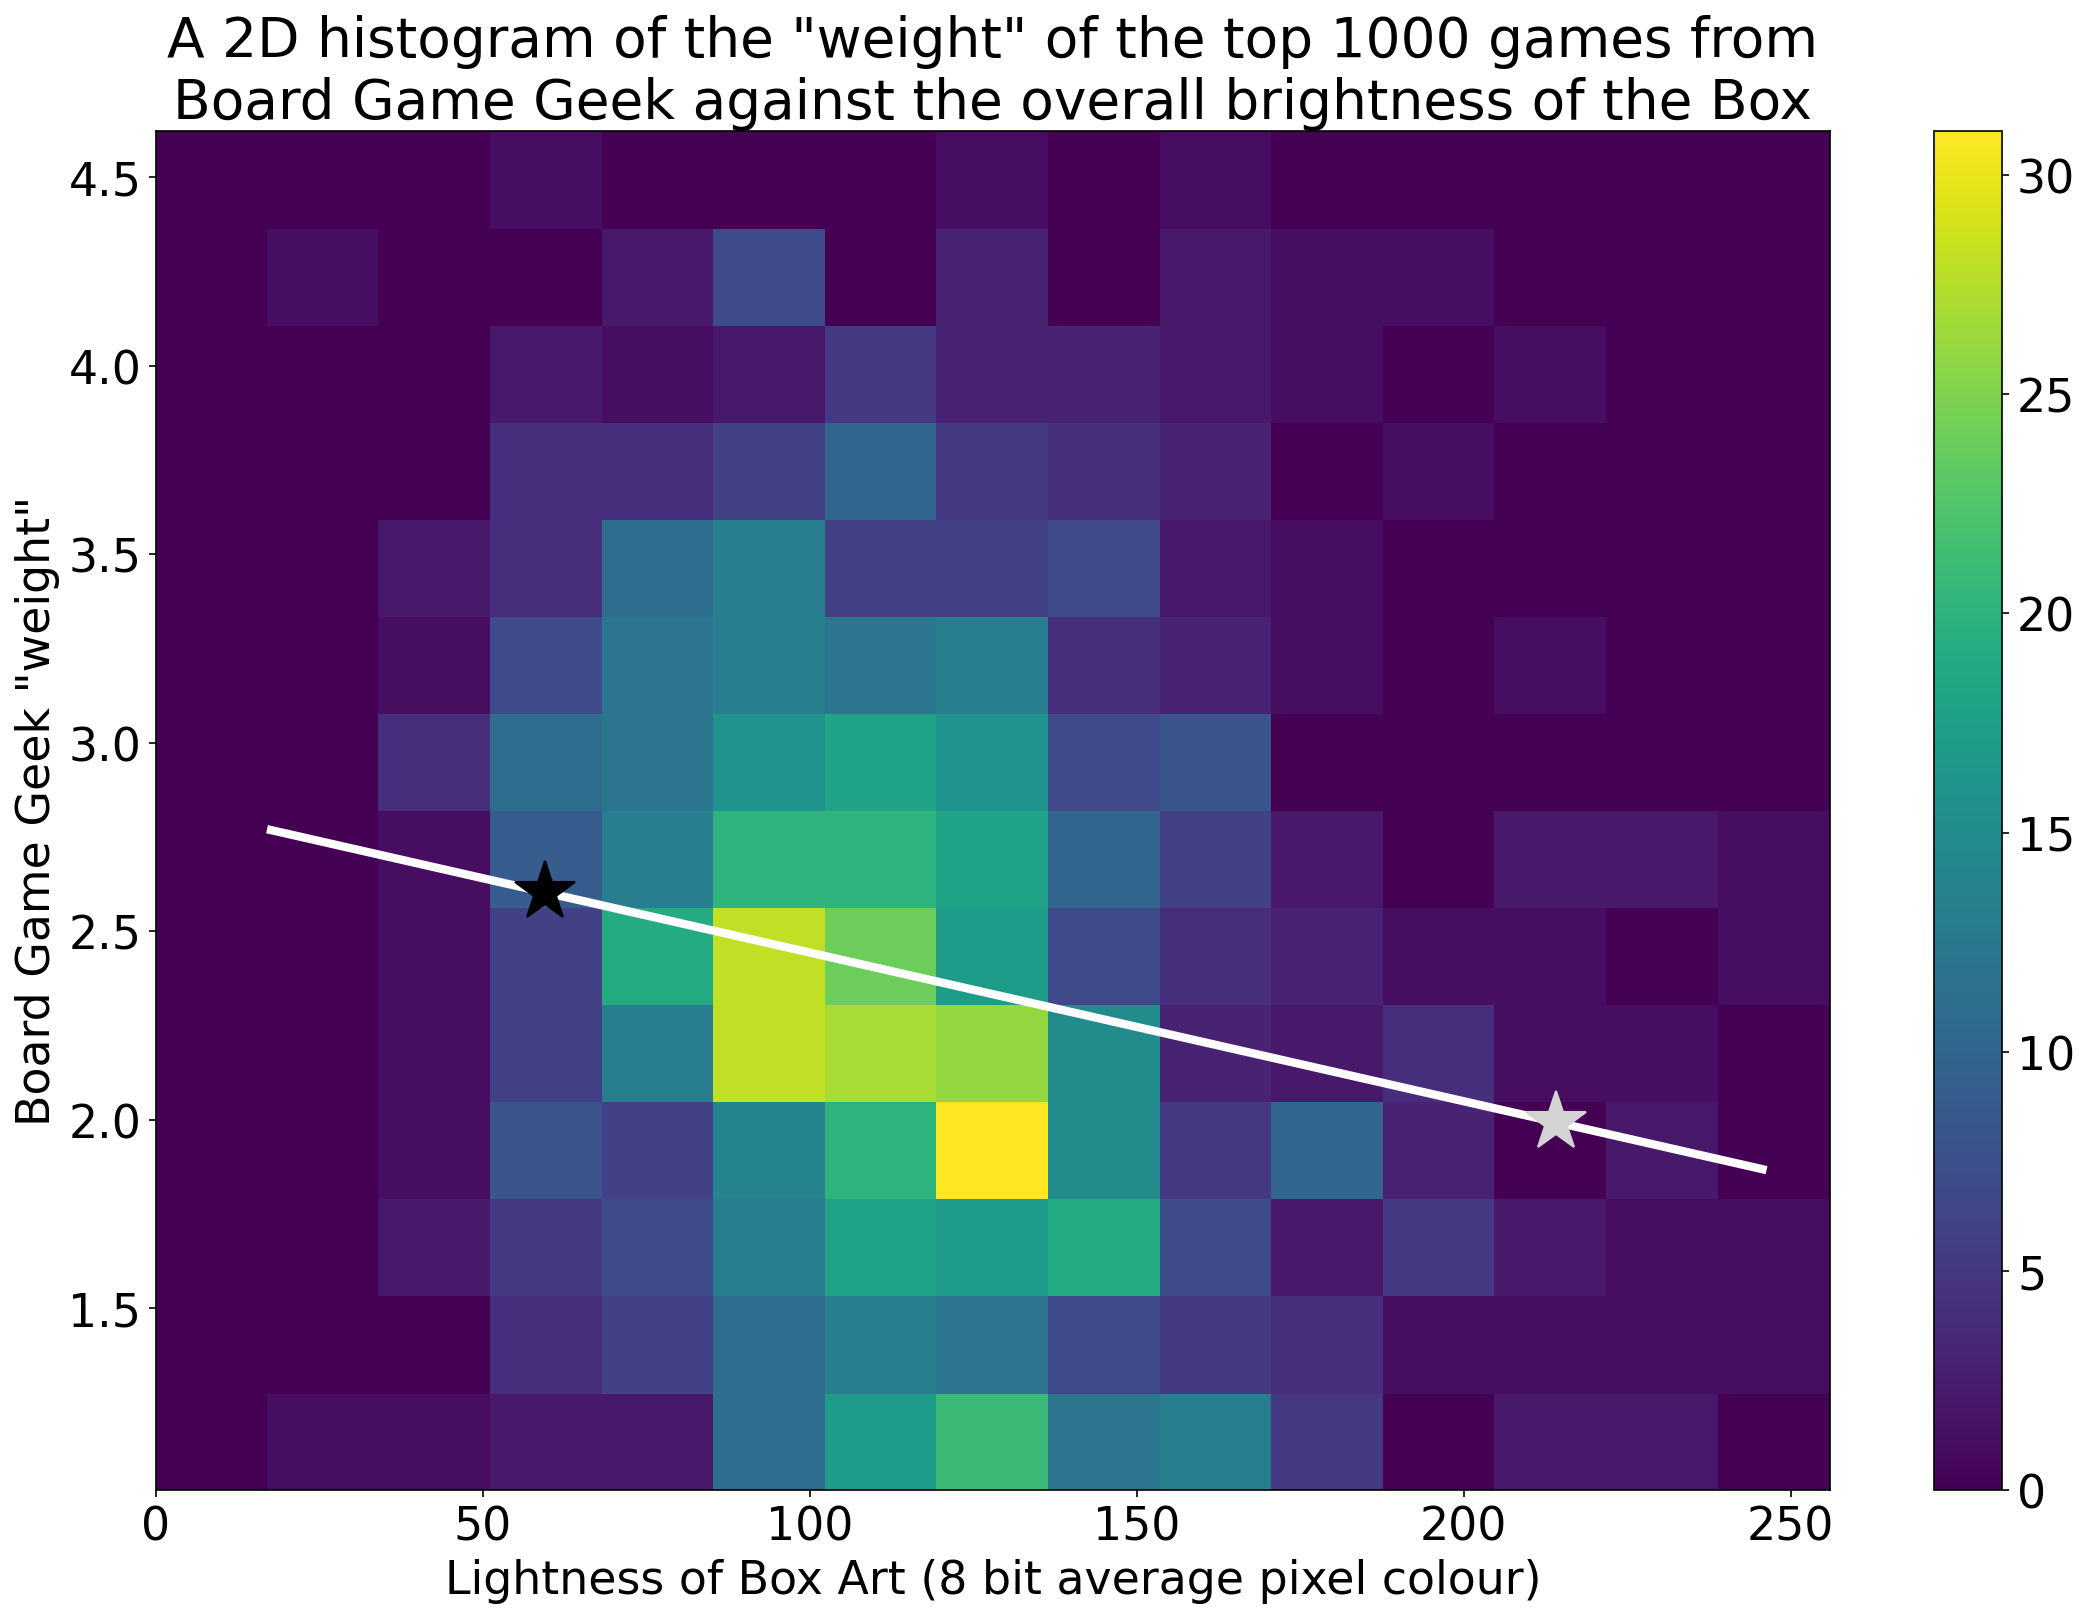

In [8]:
#Plot the supplimentary figure from the paper
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 12), dpi= 150, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
x = intensity
y = avgweight
x_bins = np.linspace(0,256,16)
y_bins = np.linspace(y.min(),y.max(),15)
plt.hist2d(x, y, bins=[x_bins,y_bins])
plt.title('A 2D histogram of the "weight" of the top 1000 games from\nBoard Game Geek against the overall brightness of the Box')
plt.xlabel('Lightness of Box Art (8 bit average pixel colour)')
plt.ylabel('Board Game Geek "weight"')
plt.colorbar()
from numpy.polynomial.polynomial import polyfit
pf = polyfit(x, y, 1)
plt.plot(np.unique(x), pf[0] + pf[1] * np.unique(x), '-', label='Trend', linewidth=4, color='white')

lightval = imread("LightBox.png").mean()
darkval = imread("DarkBox.png").mean()

plt.plot(lightval, pf[0] + pf[1] * np.unique(lightval), '*', label='Light', color='lightgray', markersize=30)
plt.plot(darkval, pf[0] + pf[1] * np.unique(darkval), '*', label='Light', color='black', markersize=30)